In [1]:
import pandas as pd
import numpy as np

import datetime
import math
import json

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
from PIL import ImageEnhance
from scipy import interpolate

import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model, load_model

2023-12-19 12:41:26.184196: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 12:41:26.213806: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-19 12:41:26.213832: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-19 12:41:26.213861: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-19 12:41:26.220148: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-19 12:41:26.220581: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [4]:
def distance(origin, destination):
    """
    Calculate the Haversine distance.

    Parameters
    ----------
    origin : tuple of float
        (lat, long)
    destination : tuple of float
        (lat, long)

    Returns
    -------
    distance_in_km : float

    Examples
    --------
    >>> origin = (48.1372, 11.5756)  # Munich
    >>> destination = (52.5186, 13.4083)  # Berlin
    >>> round(distance(origin, destination), 1)
    504.2
    """
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371  # km

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c

    return d


In [5]:
df = pd.read_csv('dataset/train.csv')
# df = df.dropna()
df = df.sample(frac=0.20)
df = df[['TRIP_ID','TIMESTAMP', 'DAY_TYPE', 'MISSING_DATA', 'POLYLINE']]
# df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'],unit='s')
# df.to_csv('dataset/sample_01.csv', sep=';', index = False)
df

,TRIP_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
370656,1379773179620000386,1379773179,A,False,"[[-8.585586,41.148576],[-8.585667,41.1489],[-8..."
1269538,1396531434620000463,1396531434,A,False,"[[-8.603847,41.159277],[-8.603316,41.162175],[..."
1616946,1402566036620000504,1402566036,A,False,"[[-8.628102,41.157729],[-8.626914,41.157531],[..."
1036509,1392066387620000295,1392066387,A,False,"[[-8.571447,41.157792],[-8.571861,41.158071],[..."
1089526,1393061797620000225,1393061797,A,False,"[[-8.58258,41.180661],[-8.582454,41.180535],[-..."
...,...,...,...,...,...
917292,1389703029620000340,1389703029,A,False,"[[-8.609391,41.181849],[-8.609445,41.183118],[..."
1326529,1397569696620000319,1397569696,A,False,"[[-8.608689,41.147892],[-8.608473,41.147784],[..."
188543,1376185326620000406,1376185326,A,False,"[[-8.615268,41.147217],[-8.615439,41.147253],[..."
524151,1382419823620000460,1382419823,A,False,"[[-8.57727,41.163156],[-8.577828,41.161446],[-..."


In [6]:
trajectories = [json.loads(x[4]) for x in df.values]
print(len(trajectories))
trajectories = [x for x in trajectories if len(x) >= 30 and len(x) <= 40]
print(len(trajectories))

342134
70841


In [7]:
bad_trajectories = []
bad_trajectories_id = []
all_distances = []

good_trajectories = []

for j, trajectory in enumerate(trajectories):
    flag = False
    for i in range(1, len(trajectory)):
        dist = distance(trajectory[i-1], trajectory[i])
        all_distances.append(dist)
        if dist <= 0.0 or dist >= 1:
            bad_trajectories.append(trajectory)
            bad_trajectories_id.append(j)
            flag = True
    if flag is False:
        good_trajectories.append(trajectory)

min(all_distances), max(all_distances), len(bad_trajectories), len(good_trajectories)

(0.0, 37.651352596393004, 24821, 51905)

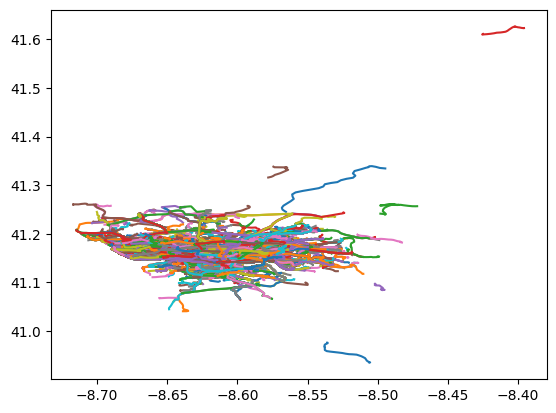

In [8]:
def plot_trajectories(trajectories):
    for trajectory in trajectories:
        first_x = 0# -trajectory[0][0]
        first_y = 0# -trajectory[0][1]
        x = [c[0]+first_x for c in trajectory]
        y = [c[1]+first_y for c in trajectory]
        plt.plot(x, y, zorder=0)
    # plt.scatter([x[0]],[y[0]],color='black',s=150,zorder=0)
    plt.show()

plot_trajectories(good_trajectories)

In [9]:
# interpolate trajectories
interpolated_trajectories = []

for i, trajectory in enumerate(good_trajectories):
    flag = False
    x = [x for x,_ in trajectory]
    y = [y for _,y in trajectory]
    tck,u=interpolate.splprep([x,y],s=0.0)
    x_i,y_i= interpolate.splev(np.linspace(0,1,100),tck)
    interpolated_t = [[x_i[i],y_i[i]] for i in range(len(x_i))]
    interpolated_trajectories.append(interpolated_t)

len(good_trajectories), len(interpolated_trajectories)

(51905, 51905)

In [11]:
def tr_to_img(trajectory):
    x = [c[0] for c in trajectory]
    y = [c[1] for c in trajectory]
    plt.scatter([x],[y],color='black',s=25)
    plt.show()

# def find_idx_grid(x_bounds, y_bounds, point):
def tr_to_grid(trajectory, N=64):
    max_x = max([x for x,_ in trajectory])
    min_x = min([x for x,_ in trajectory])
    max_y = max([y for _,y in trajectory])
    min_y = min([y for _,y in trajectory])
    min_x -= 0.001
    max_x += 0.001
    min_y -= 0.001
    max_y += 0.001
    x_bounds = [
        [min_x + (i*(max_x-min_x))/(N), min_x + ((i+1)*(max_x-min_x))/(N)] for i in range(N)
    ]
    y_bounds = [
        [min_y + (i*(max_y-min_y))/(N), min_y + ((i+1)*(max_y-min_y))/(N)] for i in range(N)
    ]
    # print(min_x, max_x)
    # print(x_bounds)
    # print(min_y, max_y)
    # print(y_bounds)
    grid = [[0]*N for i in range(N)]
    for point in trajectory:
        # print(point)
        for i, cx in enumerate(x_bounds):
            if point[0] >= cx[0] and point[0] <= cx[1]:
                # print(i, cx, point[0])
                for j, cy in enumerate(y_bounds):
                    if point[1] >= cy[0] and point[1] <= cy[1]:
                        # print(j, cy, point[1])
                        # print(j,i)
                        grid[N-j-1][i] = 1
                        # for g in grid:
                        #     print(g)
                        # print('=========================')
    # width = 256
    # height = 256
    # start_x, start_y = 0, 0
    # grid_size = width/N
    # img = Image.new("1", (width, height), (1))
    # coords_list = []
    # for i, row in enumerate(grid):
    #     for j, g in enumerate(row):
    #         if grid[i][j] == 1:
    #             coords_list.append([j*grid_size, i*grid_size, (j+1)*grid_size, (i+1)*grid_size])
    
    # img1 = ImageDraw.Draw(img)
    # for coord in  coords_list:
    #     img1.rectangle(coord,fill =(0))
    # img.show()
    img = np.asarray(grid)
    # print(img.shape)
    return img

# images = [tr_to_grid(tr) for tr in interpolated_trajectories]

# images[666]

In [9]:
# for trajectory in good_trajectories
max_x = max([max([x for x,_ in tr]) for tr in good_trajectories])
min_x = min([min([x for x,_ in tr]) for tr in good_trajectories])
max_y = max([max([y for _,y in tr]) for tr in good_trajectories])
min_y = min([min([y for _,y in tr]) for tr in good_trajectories])

print(min_x, max_x, min_y, max_y)
min_x -= 0.001
max_x += 0.001
min_y -= 0.001
max_y += 0.001
print(min_x, max_x, min_y, max_y)

-8.714862 -7.98795 40.206024 41.300055
-8.715862 -7.986949999999999 40.205024 41.301055


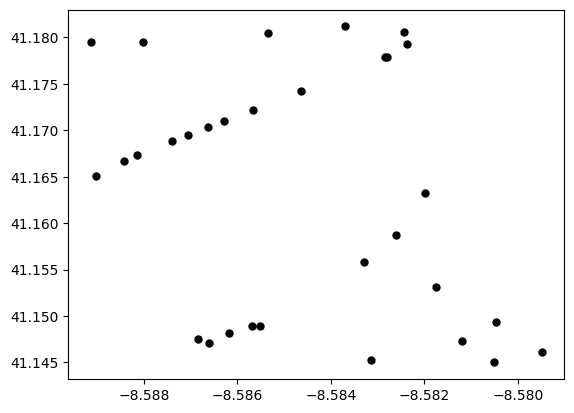

In [10]:
tr_to_img(good_trajectories[26])

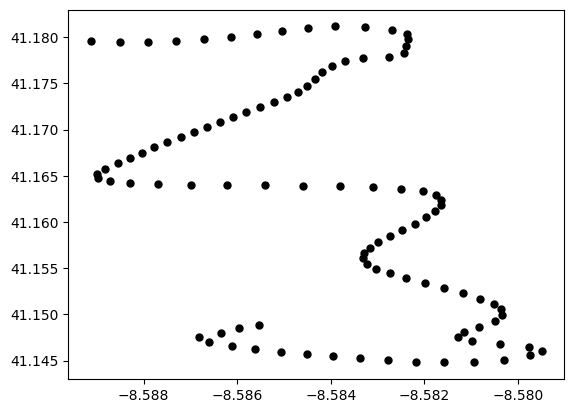

In [11]:
tr_to_img(interpolated_trajectories[26])

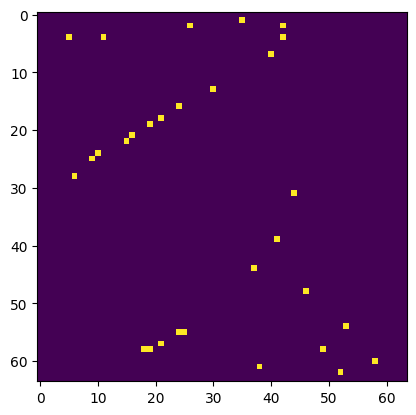

In [12]:
plt.imshow(tr_to_grid(good_trajectories[26]))

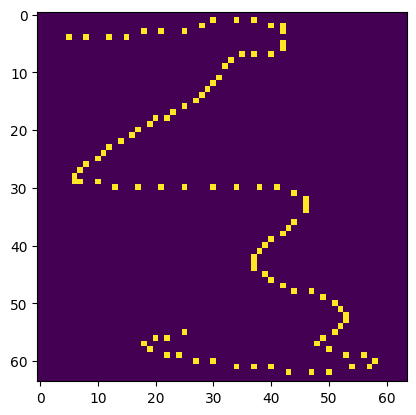

In [13]:
plt.imshow(tr_to_grid(interpolated_trajectories[26]))

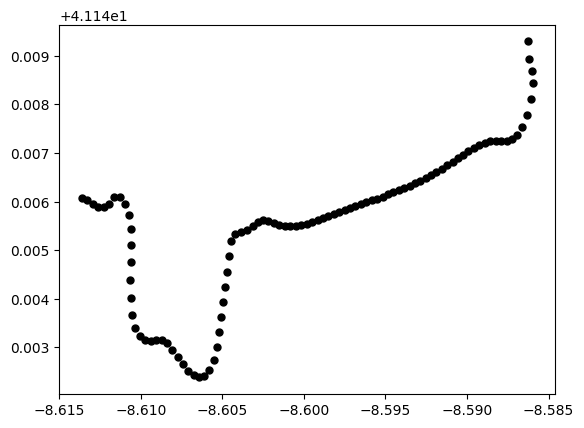

In [12]:
images = [tr_to_grid(tr, 64) for tr in interpolated_trajectories]

tr_to_img(interpolated_trajectories[666])

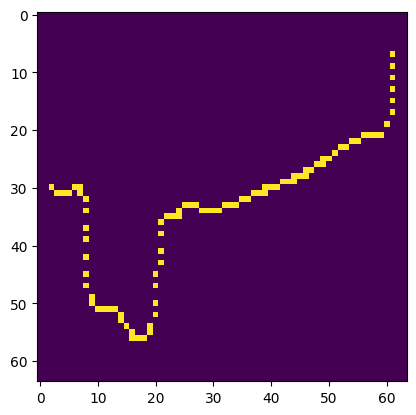

In [13]:
plt.imshow(images[666])

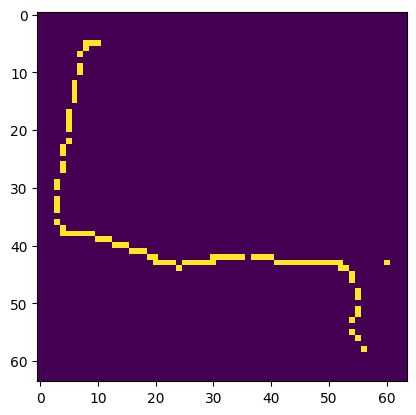

In [14]:
plt.imshow(images[26])

## Training

In [15]:
from sklearn.model_selection import train_test_split
# Training
print(len(images))
# img size = 600x600
X = images.copy()


X_train, X_test, _, _ = train_test_split(X, X, test_size=0.30)
# X_test, X_val, y_train, y_val  = train_test_split(X_test, X_test, test_size=0.5)

len(X_train), len(X_test)

51905


(36333, 15572)

In [16]:
X_train = np.asarray(X_train, dtype=np.float32)
X_test = np.asarray(X_test, dtype=np.float32)
# X_val = np.asarray(X_val, dtype=np.float32)

X_train.shape

(36333, 64, 64)

In [17]:
X_train = X_train[..., tf.newaxis]
X_test = X_test[..., tf.newaxis]
print(X_train.shape)
print(X_test.shape)

(36333, 64, 64, 1)
(15572, 64, 64, 1)


In [20]:
np.save('saved_models/nuevo_X_train_12_10_23.npy', X_train) # save
np.save('saved_models/nuevo_X_test_12_10_23.npy', X_test) # save

In [19]:
raise Exception('hola')

Exception: hola

In [63]:
encoder = tf.keras.Sequential([
            layers.Input(shape=(64, 64,1), name='enc_1'),
            layers.Conv2D(filters=16, kernel_size=(8, 8), activation='relu', padding='same', name='enc_2'),
            layers.MaxPooling2D(pool_size=(2, 2), name='enc_3'),
            layers.Conv2D(filters=16, kernel_size=(6, 6), padding='same',activation='relu', name='enc_4'),
            layers.MaxPooling2D(pool_size=(2, 2), name='enc_5'),
            layers.Conv2D(filters=8, kernel_size=(4, 4), padding='same',activation='relu', name='enc_6'),
            layers.MaxPooling2D(pool_size=(2, 2), name='enc_7'),
            layers.Conv2D(filters=8, kernel_size=(2, 2), padding='same',activation='relu', name='enc_8'),
            layers.MaxPooling2D(pool_size=(2, 2), name='enc_9'),
            layers.Flatten(name='enc_10'),
            layers.Dense(32)
        ])
encoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
encoder.build((64,64,1))
encoder.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 enc_2 (Conv2D)              (None, 64, 64, 16)        1040      
                                                                 
 enc_3 (MaxPooling2D)        (None, 32, 32, 16)        0         
                                                                 
 enc_4 (Conv2D)              (None, 32, 32, 16)        9232      
                                                                 
 enc_5 (MaxPooling2D)        (None, 16, 16, 16)        0         
                                                                 
 enc_6 (Conv2D)              (None, 16, 16, 8)         2056      
                                                                 
 enc_7 (MaxPooling2D)        (None, 8, 8, 8)           0         
                                                                 
 enc_8 (Conv2D)              (None, 8, 8, 8)          

In [64]:
decoder = tf.keras.Sequential([
            layers.Input(shape=(32)),
            layers.Dense(128),
            layers.Reshape((4, 4, 8)),
            layers.UpSampling2D(size=(2, 2)),
            layers.Conv2DTranspose(filters=8, kernel_size=(2, 2), activation='relu', padding='same', name='dec_1'),
            layers.UpSampling2D(size=(2, 2)),
            layers.Conv2DTranspose(filters=8, kernel_size=(4, 4), activation='relu', padding='same', name='dec_2'),
            layers.UpSampling2D(size=(2, 2)),
            layers.Conv2DTranspose(filters=16, kernel_size=(6, 6), activation='relu', padding='same', name='dec_3'),
            layers.UpSampling2D(size=(2, 2)),
            layers.Conv2DTranspose(filters=16, kernel_size=(8, 8), activation='relu', padding='same', name='dec_4'),
            layers.Conv2DTranspose(filters=1, kernel_size=(1, 1), activation='relu', padding='same', name='dec_5')
        ])
decoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
decoder.build((32))
decoder.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               4224      
                                                                 
 reshape_4 (Reshape)         (None, 4, 4, 8)           0         
                                                                 
 up_sampling2d_10 (UpSampli  (None, 8, 8, 8)           0         
 ng2D)                                                           
                                                                 
 dec_1 (Conv2DTranspose)     (None, 8, 8, 8)           264       
                                                                 
 up_sampling2d_11 (UpSampli  (None, 16, 16, 8)         0         
 ng2D)                                                           
                                                                 
 dec_2 (Conv2DTranspose)     (None, 16, 16, 8)        

In [18]:
class AE(Model):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(64, 64,1), name='enc_1'),
            layers.Conv2D(filters=16, kernel_size=(8, 8), activation='relu', padding='same', name='enc_2'),
            layers.MaxPooling2D(pool_size=(2, 2), name='enc_3'),
            layers.Conv2D(filters=16, kernel_size=(4, 4),padding='same',activation='relu', name='enc_4'),
            layers.MaxPooling2D(pool_size=(2, 2), name='enc_5'),
            layers.Flatten(name='enc_6'),
            layers.Dense(128)
        ])
        self.decoder = tf.keras.Sequential([
            layers.Input(shape=(128)),
            layers.Dense(512),
            layers.Reshape((8, 8, 8)),
            layers.UpSampling2D(size=(2, 2)),
            layers.Conv2DTranspose(filters=8, kernel_size=(4, 4), activation='relu', padding='same', name='dec_1'),
            layers.UpSampling2D(size=(2, 2)),
            layers.Conv2DTranspose(filters=16, kernel_size=(6, 6), activation='relu', padding='same', name='dec_2'),
            layers.UpSampling2D(size=(2, 2)),
            layers.Conv2DTranspose(filters=16, kernel_size=(8, 8), activation='relu', padding='same', name='dec_3'),
            layers.Conv2DTranspose(filters=1, kernel_size=(1, 1), activation='relu', padding='same', name='dec_4')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AE()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

2023-12-19 12:49:55.762125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-19 12:49:55.763113: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [49]:
class AE2(Model):
    def __init__(self):
        super(AE2, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(64, 64,1), name='enc_1'),
            layers.Conv2D(filters=16, kernel_size=(8, 8), activation='relu', padding='same', name='enc_2'),
            layers.MaxPooling2D(pool_size=(2, 2), name='enc_3'),
            layers.Conv2D(filters=16, kernel_size=(6, 6), padding='same',activation='relu', name='enc_4'),
            layers.MaxPooling2D(pool_size=(2, 2), name='enc_5'),
            layers.Conv2D(filters=8, kernel_size=(4, 4), padding='same',activation='relu', name='enc_6'),
            layers.MaxPooling2D(pool_size=(2, 2), name='enc_7'),
            layers.Flatten(name='enc_8'),
            layers.Dense(32)
        ])
        self.decoder = tf.keras.Sequential([
            layers.Input(shape=(32)),
            layers.Dense(2048),
            layers.Reshape((16,16,8)),
            layers.UpSampling2D(size=(2, 2)),
            layers.Conv2DTranspose(filters=8, kernel_size=(4, 4), activation='relu', padding='same', name='dec_2'),
            layers.UpSampling2D(size=(2, 2)),
            layers.Conv2DTranspose(filters=16, kernel_size=(8, 8), activation='relu', padding='same', name='dec_3'),
            layers.Conv2DTranspose(filters=1, kernel_size=(2, 2), activation='relu', padding='same', name='dec_4')
            # layers.Dense(1, activation='sigmoid')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AE2()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [142]:
class AE3(Model):
    def __init__(self):
        super(AE3, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(64, 64,1), name='enc_1'),
            layers.Conv2D(filters=16, kernel_size=(8, 8), activation='relu', padding='same', name='enc_2'),
            layers.MaxPooling2D(pool_size=(2, 2), name='enc_3'),
            layers.Conv2D(filters=16, kernel_size=(6, 6), padding='same',activation='relu', name='enc_4'),
            layers.MaxPooling2D(pool_size=(2, 2), name='enc_5'),
            layers.Conv2D(filters=8, kernel_size=(4, 4), padding='same',activation='relu', name='enc_6'),
            layers.MaxPooling2D(pool_size=(2, 2), name='enc_7'),
            layers.Conv2D(filters=8, kernel_size=(2, 2), padding='same',activation='relu', name='enc_8'),
            layers.MaxPooling2D(pool_size=(2, 2), name='enc_9'),
            layers.Flatten(name='enc_10'),
            layers.Dense(32)
        ])
        self.decoder = tf.keras.Sequential([
            layers.Input(shape=(32)),
            layers.Dense(128),
            layers.Reshape((4, 4, 8)),
            layers.UpSampling2D(size=(2, 2)),
            layers.Conv2DTranspose(filters=8, kernel_size=(2, 2), activation='relu', padding='same', name='dec_1'),
            layers.UpSampling2D(size=(2, 2)),
            layers.Conv2DTranspose(filters=8, kernel_size=(4, 4), activation='relu', padding='same', name='dec_2'),
            layers.UpSampling2D(size=(2, 2)),
            layers.Conv2DTranspose(filters=16, kernel_size=(6, 6), activation='relu', padding='same', name='dec_3'),
            layers.UpSampling2D(size=(2, 2)),
            layers.Conv2DTranspose(filters=1, kernel_size=(8, 8), activation='relu', padding='same', name='dec_4'),
            # layers.Conv2DTranspose(filters=1, kernel_size=(1, 1), activation='relu', padding='same', name='dec_5')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = AE3()
autoencoder.compile(optimizer='adam', loss=losses.MeanAbsoluteError())

In [19]:
autoencoder.fit(X_train, X_train,
                epochs=10,
                shuffle=True,
                batch_size=32,
                validation_data=(X_test, X_test))

Epoch 1/10
1136/1136 [==============================] - 361s 317ms/step - loss: 0.0155 - val_loss: 0.0132
Epoch 2/10
1136/1136 [==============================] - 361s 318ms/step - loss: 0.0122 - val_loss: 0.0116
Epoch 3/10
1136/1136 [==============================] - 362s 319ms/step - loss: 0.0110 - val_loss: 0.0107
Epoch 4/10
1136/1136 [==============================] - 360s 317ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 5/10
1136/1136 [==============================] - 359s 316ms/step - loss: 0.0099 - val_loss: 0.0100
Epoch 6/10
1136/1136 [==============================] - 359s 316ms/step - loss: 0.0096 - val_loss: 0.0097
Epoch 7/10
1136/1136 [==============================] - 361s 318ms/step - loss: 0.0094 - val_loss: 0.0096
Epoch 8/10
1136/1136 [==============================] - 361s 318ms/step - loss: 0.0092 - val_loss: 0.0095
Epoch 9/10
1136/1136 [==============================] - 363s 320ms/step - loss: 0.0091 - val_loss: 0.0094
Epoch 10/10
 100/1136 [=>.....................

KeyboardInterrupt: 

In [20]:
autoencoder.summary()

Model: "ae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 128)               529568    
                                                                 
 sequential_1 (Sequential)   (None, 64, 64, 1)         88121     
                                                                 
Total params: 617689 (2.36 MB)
Trainable params: 617689 (2.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
autoencoder.save('saved_models/autoencoder_2conv_10epoch_vector64')

INFO:tensorflow:Assets written to: saved_models/autoencoder_2conv_10epoch_vector64/assets


INFO:tensorflow:Assets written to: saved_models/autoencoder_2conv_10epoch_vector64/assets


In [26]:
np.save('saved_models/X_test_nuevo.npy', X_test) # save
# new_num_arr = np.load('data.npy') # load

In [29]:
# new_num_arr = np.load('saved_models/X_test.npy') # load

# new_num_arr[0].shape

(256, 256, 1)

In [73]:
new_model = load_model('saved_models/autoencoder_1epoch64')

In [43]:
prueba = X_test[0:20]

In [44]:
encoded_imgs = autoencoder.encoder(prueba).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

NameError: name 'prueba' is not defined

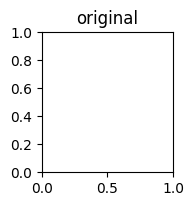

In [81]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(prueba[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

In [32]:
encoded_imgs.shape

(20, 32)

In [50]:
decoded_imgs[4].max()

0.28258282

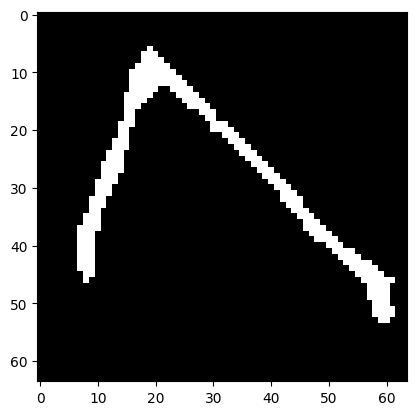

In [53]:
img_prueba = np.where(
    decoded_imgs[3] > 0.1, 1, decoded_imgs[3]
)

img_prueba = np.where(
    img_prueba <= 0.1, 0, img_prueba
)

plt.imshow(img_prueba)

In [90]:
new_model = tf.keras.models.load_model('saved_models/autoencoder_5epoch64')
new_model.summary()

Model: "ae_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_16 (Sequential)  (None, 32)                136256    
                                                                 
 sequential_17 (Sequential)  (None, 64, 64, 1)         76889     
                                                                 
Total params: 213145 (832.60 KB)
Trainable params: 213145 (832.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
encoded_imgs = autoencoder.encoder(X_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
encoded_imgs.shape

2023-12-19 13:45:13.046392: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4082106368 exceeds 10% of free system memory.
2023-12-19 13:45:14.405218: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4082106368 exceeds 10% of free system memory.
2023-12-19 13:45:15.046396: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4082106368 exceeds 10% of free system memory.
2023-12-19 13:45:22.363636: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4082106368 exceeds 10% of free system memory.
2023-12-19 13:45:22.729118: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 4082106368 exceeds 10% of free system memory.


(15572, 128)

In [28]:
decoded_imgs.shape, X_test.shape

((15636, 64, 64, 1), (15636, 64, 64, 1))

In [104]:
from sklearn.metrics import mean_squared_error

mse = 0
for i in range(X_test.shape[0]):
    mse += mean_squared_error(tf.squeeze(X_test[i]), tf.squeeze(decoded_imgs[i]))

mse/X_test.shape[0]

0.017126593757233945

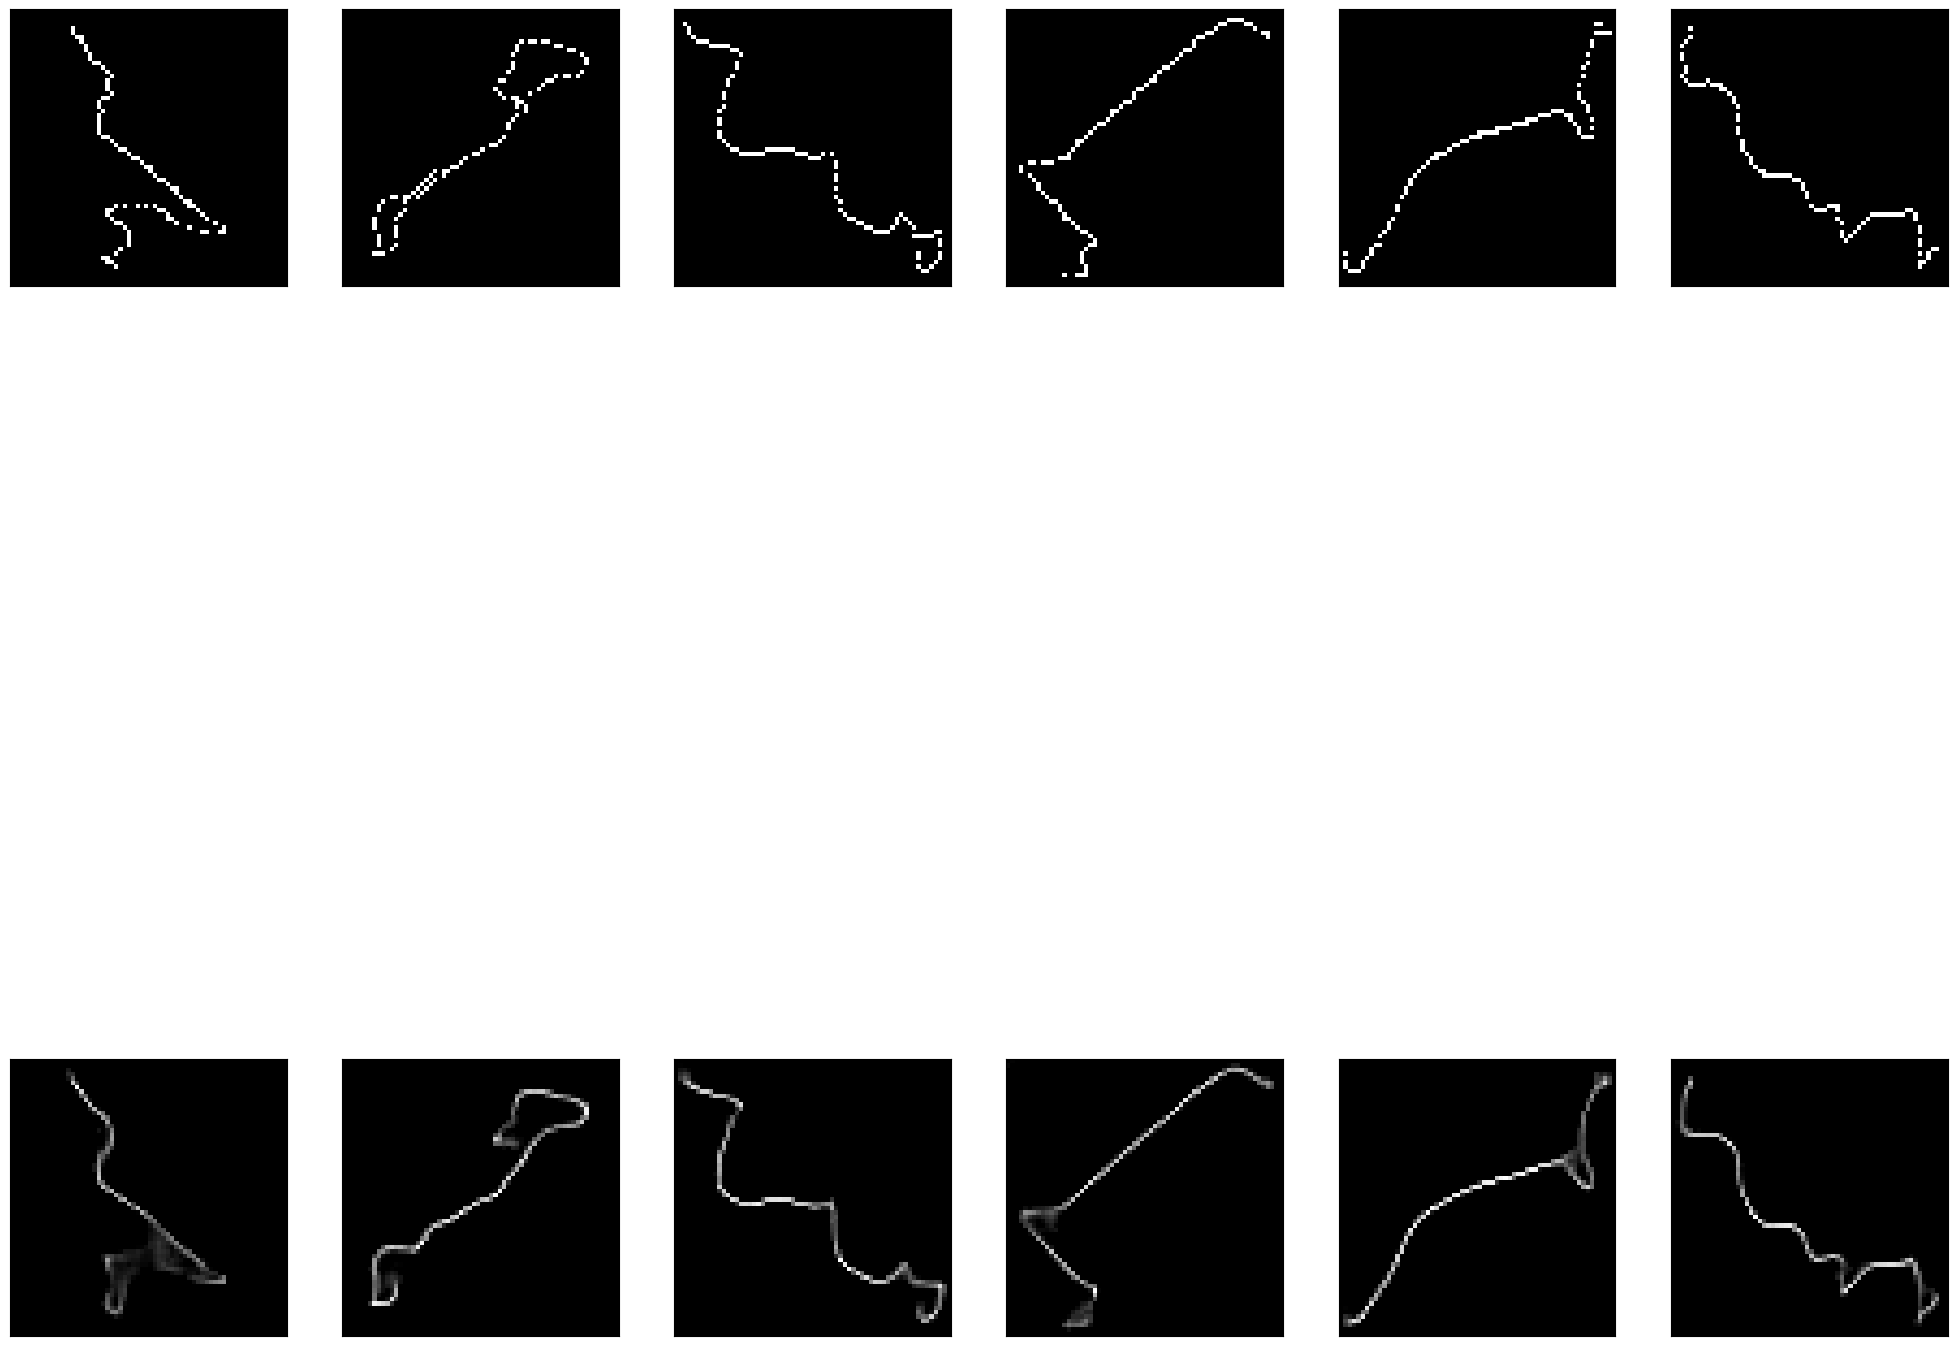

In [22]:
n = 6
plt.figure(figsize=(25, 25))
for i in range(n):
    a = i+1500
    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    # plt.title("original")
    plt.imshow(tf.squeeze(X_test[a]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    # plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[a]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

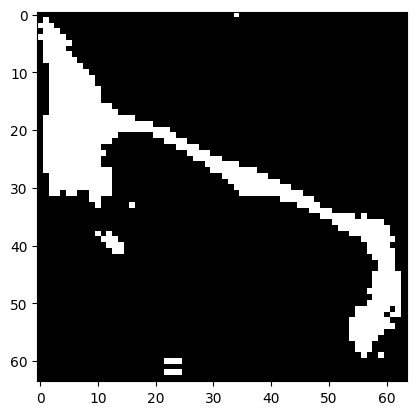

In [85]:
img_prueba = np.where(
    decoded_imgs[102] != 0, 1, decoded_imgs[102]
)

# img_prueba = np.where(
#     img_prueba <= 0.1, 0, img_prueba
# )

plt.imshow(img_prueba)

In [23]:
from sklearn.cluster import HDBSCAN

hdb = HDBSCAN()
hdb.fit(encoded_imgs)

HDBSCAN()

In [24]:
labels = hdb.labels_.tolist()
len(labels)

15572

In [32]:
len(set(labels))

429

In [106]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=50, n_init="auto").fit(encoded_imgs)

labels = kmeans.labels_.tolist()
len(labels)

11465

13


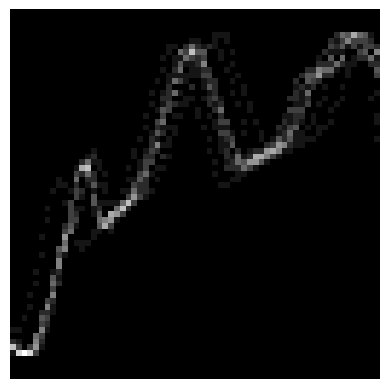

In [36]:
# 30, 40, 7
c = 66
imgs = np.zeros(X_test[0].shape)
hola = []
for i, l in enumerate(labels):
    if l == c:
        imgs += X_test[i]
        hola.append(X_test[i])

print(len(hola))
plt.axis('off')
plt.imshow(imgs)

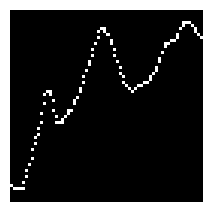

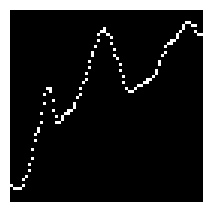

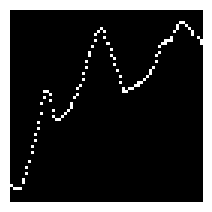

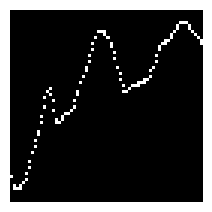

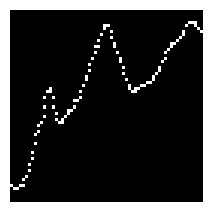

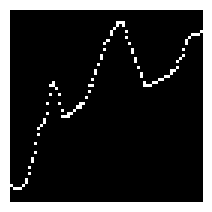

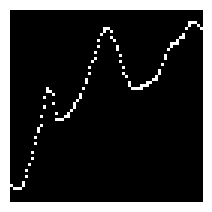

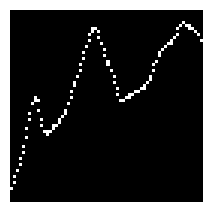

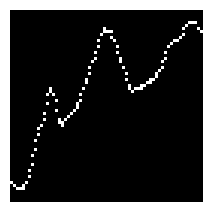

In [37]:
for i,j in enumerate(hola):
    if i < 9:
        plt.figure(figsize=(2.5, 2.5))
        plt.axis('off')
        plt.imshow(j)
        plt.show()

In [166]:
np.save('saved_models/X_test_final.npy', X_test) # save